In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors

In [4]:
%matplotlib inline

In [6]:
df = pd.read_csv('data.csv')

### Clean raw data

In [4]:
def strtolistc(val):
    """Convert string to list of floats"""
    ls = val.strip('[]').split(',')
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))
def strtolist(val):
    """Convert string to list of floats"""
    ls = val.strip('[]').replace(',', '').split()
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))

In [5]:
df['d_heuristics'] = df['d_heuristics'].apply(strtolist)
df['x_heuristics'] = df['x_heuristics'].apply(strtolist)
df['d_set'] = df['d_heuristics'].map(lambda x: set(x))
df['x_set'] = df['x_heuristics'].map(lambda x: set(x))
df['d_cover'] = df['d_set'].map(lambda x: len(x))
df['x_cover'] = df['x_set'].map(lambda x: len(x))

"""Diversity trumps ability"""
df['dta'] = df['diverse'] > df['expert'] # Frequency
df['dta'] = df['dta'].map(lambda x: int(x))

df['diff'] = df['diverse'] - df['expert'] # Diff mean score

In [6]:
model = smf.ols('diff ~ sigma + sigma:trust + trust', data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     2358.
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:47:31   Log-Likelihood:                -31112.
No. Observations:               26174   AIC:                         6.223e+04
Df Residuals:                   26170   BIC:                         6.227e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3276      0.013     24.857      0.000       0.302       0.353
sigma          -0.0477      0.002    -25.286      0.000      -0.051      -0.044
sigma:trust     0.1313      0.003     40.512      0.000       0.125       0.138
trust           0.2614      0.023     11.535      0.000       0.217       0.306
==============================================================================
Omnibus:                     1978.535   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3352.511
Skew:                           0.570   Prob(JB):                         0.00
Kurtosis:                       4.332   Cond. No.                         40.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Check cover diversity

<Axes: >

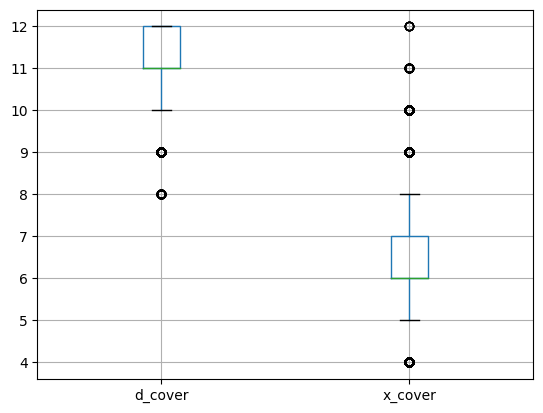

In [7]:
df.boxplot(column=['d_cover', 'x_cover'])

### Noise and smoothness

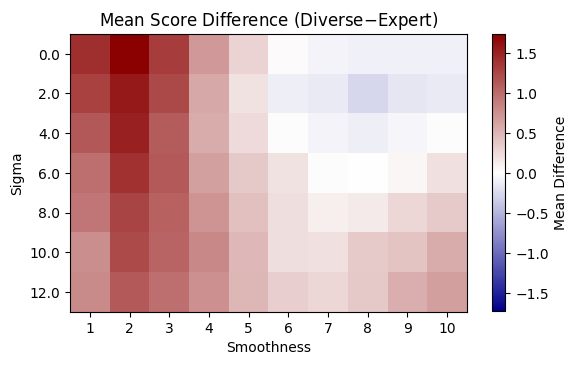

In [8]:
selected = df[df['trust']==0.33]
grouped_df = df.groupby(['smoothness', 'sigma'])['diff'].mean().reset_index()
pivot_table = grouped_df.pivot(index='sigma', columns='smoothness', values='diff')

colors = ['darkblue', 'white', 'darkred']

# Create a custom colormap with specified colors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', colors)

# Normalize the data for the colormap
norm = mcolors.TwoSlopeNorm(vmin=-pivot_table.values.max(), vcenter=0, vmax=pivot_table.values.max())
# Plot the heatmap with the custom colormap and normalization
plt.imshow(pivot_table.values, cmap=cmap, norm=norm, aspect='equal', interpolation='none')
# plt.imshow(pivot_table.values, cmap='gray', aspect='equal', interpolation='none')

# Add color bar
cbar = plt.colorbar(label='Mean Difference', shrink=0.75)

# Set axis labels and title
plt.xlabel('Smoothness')
plt.ylabel('Sigma')
plt.title('Mean Score Difference (Diverse$-$Expert)')

# Set tick labels
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

# plt.savefig('../graphs/Sig_Sm.png', dpi=400, bbox_inches='tight')

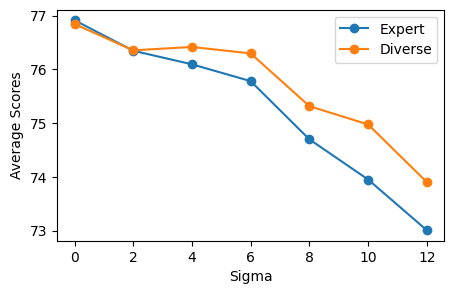

In [43]:
# Group the data by 'sigma' and calculate the average for 'expert' and 'diverse' columns
selected = df[(df['smoothness']==8)&(df['trust']==1)]
grouped = selected[['diverse', 'expert', 'sigma']].groupby('sigma').mean()

plt.figure(figsize=(5, 3))
plt.plot(grouped.index, grouped['expert'], marker='o', label='Expert')
plt.plot(grouped.index, grouped['diverse'], marker='o', label='Diverse')
plt.xlabel('Sigma')
plt.ylabel('Average Scores')
# plt.title('Average Scores of Expert and Diverse by Sigma')
# plt.ylim(72, 79)
plt.legend()
# plt.grid(True)

# plt.savefig('../graphs/Score_Sigma_sm=8_trust=1.png', dpi=400, bbox_inches='tight')

### Plot "diveristy trumps ability" frequency

In [33]:
sigma = 4
dta = df[(df['sigma']==sigma)][['dta', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['dta'].sum().to_frame().unstack()
dta = dta['dta']
count = df[(df['sigma']==sigma)][['dta', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['dta'].count().to_frame().unstack()
count = count['dta']
dta = dta/count

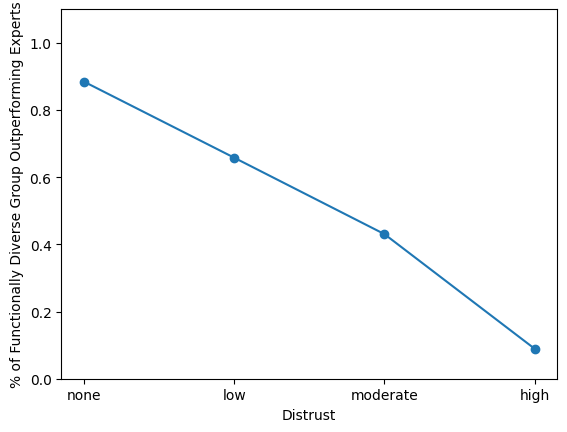

In [38]:
fig, ax = plt.subplots()
data = list(dta[6])
data.reverse()
ax.plot(data, marker='o')
ax.set_ylim(0, 1.1)
plt.xlabel('Distrust')
plt.ylabel('% of Functionally Diverse Group Outperforming Experts')
plt.xticks((0, 1, 2, 3), ['none', 'low', 'moderate', 'high'])

# plt.savefig('../graphs/freq4.png', dpi=350, bbox_inches='tight')

### Plot difference in mean score

In [35]:
diff = df[(df['sigma']==sigma)][['diff', 'trust', 'smoothness']].groupby(['trust', 'smoothness'])['diff'].mean().to_frame().unstack()
diff = diff['diff']

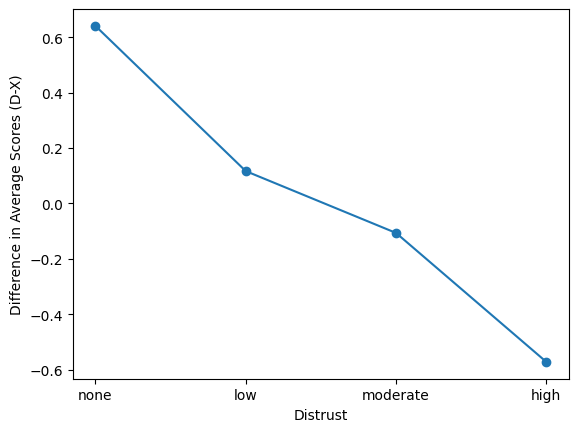

In [37]:
fig, ax = plt.subplots()
data = list(diff[6])
data.reverse()
ax.plot(data, marker='o')
    # ax.set_ylim(-1, 2.5)
plt.xlabel('Distrust')
plt.ylabel('Difference in Average Scores (D-X)')
plt.xticks((0, 1, 2, 3), ['none', 'low', 'moderate', 'high'])

# plt.savefig('../graphs/diff4.png', dpi=350, bbox_inches='tight')